In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Dataset

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

--2022-05-01 01:17:32--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip.1’

ml-100k.zip.1       100%[===================>]   4.70M  5.97MB/s    in 0.8s    

2022-05-01 01:17:34 (5.97 MB/s) - ‘ml-100k.zip.1’ saved [4924029/4924029]

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml

In [ ]:
df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamps'])
df.head()


def df_to_matrix(df: pd.DataFrame):
    max_user = df['user_id'].max() - df['user_id'].min()
    max_item = df['item_id'].max() - df['item_id'].min()
    min_user = df['user_id'].min()
    min_item = df['item_id'].min()
    matrix = np.zeros((max_user+1, max_item+1), dtype=int)

    for user_id, item_id in zip(df['user_id'], df['item_id']):
        matrix[user_id - min_user, item_id - min_item] = 1

    return matrix

#matrix = df_to_matrix(df)  # [max_user, max_item]

In [ ]:
class MFDataset(Dataset):
    def __init__(self, matrix: np.ndarray, number_of_negatives):
        """
        Input
            matrix: Matrice donnant les interactions entres les users et les items.
                Shape de [max_user, max_item] => matrix[i, j] == 1 <=> "l'utilisateur i a vu l'item j"
        """
        super().__init__()
        self.matrix = matrix
        self.max_user = matrix.shape[0]
        self.max_item = matrix.shape[1]
        self.number_of_negatives = number_of_negatives
    
    def __len__(self):
        return len(matrix)

    def __getitem__(self, user_index: int):
  
        #On récupère la ligne de la matrice correspondante à l'utilisateur
        items = matrix[user_index]

        #On récupère les interaction positives et négatives pour cet utilisateur
        items_id = np.arange(self.max_item)
        positive_items = items_id[items == 1]
        negative_items = items_id[items == 0]

        #On choisit 1 interaction positive et "number_of_negatives" interactions négatives
        positive_id = np.random.choice(positive_items, size=1)
        negative_id = np.random.choice(negative_items, size=self.number_of_negatives)

        #On transformes toutes ces interactions en vecteurs one-hot
        user_one_hot = torch.zeros(self.max_user)
        user_one_hot[user_index] = 1

        positive_item_one_hot = torch.zeros(self.max_item)
        positive_item_one_hot[positive_id] = 1

        negative_item_one_hot=torch.zeros(self.number_of_negatives, self.max_item)
        for i in range(self.number_of_negatives):
          negative_item_one_hot[i,negative_id[i]] = 1

        return user_one_hot, positive_item_one_hot, negative_item_one_hot


    def getItemsHR(self, user_index: int):

        #On récupère la ligne de la matrice correspondante à l'utilisateur
        items = self.matrix[user_index,:]

        #On récupère les interaction positives et négatives pour cet utilisateur
        items_id = np.arange(self.max_item)
        positive_items = items_id[items == 1]
        negative_items = items_id[items == 0]

        #On choisit 1 interaction positive et 99 interactions négatives
        positive_id = np.random.choice(positive_items, size=1)
        negative_id = np.random.choice(negative_items, size=99)

        #Transformation des interactions en vecteurs one-hot
        user_one_hot = torch.zeros(1,self.max_user)
        user_one_hot[0,user_index] = 1

        positive_item_one_hot = torch.zeros(1,self.max_item)
        positive_item_one_hot[0,positive_id] = 1

        negative_id=np.random.choice(negative_items, size=99)
        idx_99 = np.arange(99)

        negative_item_one_hot = torch.zeros((99,self.max_item))
        negative_item_one_hot[idx_99, negative_id] = 1

        user_one_hot_99  = torch.zeros((99,self.max_user))
        user_one_hot_99[:,user_index] = 1

        return user_one_hot, positive_item_one_hot, user_one_hot_99, negative_item_one_hot

# Models

In [ ]:
class GMF(nn.Module):
    def __init__(self, nb_users, nb_items, dim_embedding):
        super().__init__()
        self.user_emb = nn.Linear(nb_users, dim_embedding)
        self.item_emb = nn.Linear(nb_items, dim_embedding)
        self.h = nn.Parameter(torch.randn(size=(dim_embedding, 1)), requires_grad=True)

    def mid_forward(self, user_one_hot, item_one_hot):
        user_emb = self.user_emb(user_one_hot)  # [batch_size, dim_embedding]
        item_emb = self.item_emb(item_one_hot)  # [batch_size, dim_embedding]
        return user_emb * item_emb
    
    def forward(self, user_one_hot, item_one_hot):
        """
        Input
        -----
            user_one_hot: Shape of [batch_size, nb_users].
            item_one_hot: Shape of [batch_size, nb_items].
        Output
        ------
            proximity_score: Shape of [batch_size,].
        """
        proximity = self.mid_forward(user_one_hot, item_one_hot)
        proximity = proximity @ self.h
        return torch.sigmoid(proximity).flatten()

In [ ]:
class MLP(nn.Module):
    def __init__(
            self,
            nb_users,
            nb_items,
            dim_embedding,
            dim_hidden,
        ):
        super().__init__()
        self.user_emb = nn.Linear(nb_users, dim_embedding)
        self.item_emb = nn.Linear(nb_items, dim_embedding)
        self.h = nn.Parameter(torch.randn(size=(dim_hidden // 8, 1)), requires_grad=True)
        self.mlp = nn.Sequential(
            nn.Linear(dim_embedding * 2, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden // 2),
            nn.ReLU(),
            nn.Linear(dim_hidden // 2, dim_hidden // 4),
            nn.ReLU(),
            nn.Linear(dim_hidden // 4, dim_hidden // 8),
        )

    def mid_forward(self, user_one_hot, item_one_hot):

        user_emb = self.user_emb(user_one_hot)  # [batch_size, dim_embedding]
        item_emb = self.item_emb(item_one_hot)  # [batch_size, dim_embedding]

        x = torch.cat((user_emb, item_emb), dim=1)
        return self.mlp(x)

    def forward(self, user_one_hot, item_one_hot):
        """
        Input
        -----
            user_one_hot: Shape of [batch_size, nb_users].
            item_one_hot: Shape of [batch_size, nb_items].
        Output
        ------
            proximity_score: Shape of [batch_size,].
        """
        proximity = self.mid_forward(user_one_hot, item_one_hot)
        proximity = proximity @ self.h
        return torch.sigmoid(proximity).flatten()

In [ ]:
class NeuMF(nn.Module):
    def __init__(
            self,
            gmf: GMF,
            mlp: MLP,
            alpha: int,
        ):
        super().__init__()
        self.gmf = gmf
        self.mlp = mlp
        self.h = torch.cat((alpha * gmf.h.data, (1-alpha) * mlp.h.data), dim=0)
        self.h = nn.Parameter(self.h)

    def forward(self, user_one_hot, item_one_hot):
        """
        Input
        -----
            user_one_hot: Shape of [batch_size, nb_users].
            item_one_hot: Shape of [batch_size, nb_items].
        Output
        ------
            proximity_score: Shape of [batch_size, 1].
        """
        gmf_emb = self.gmf.mid_forward(user_one_hot, item_one_hot)
        mlp_emb = self.mlp.mid_forward(user_one_hot, item_one_hot)
        x = torch.cat((gmf_emb, mlp_emb), dim=1)
        proximity = x @ self.h
        return torch.sigmoid(proximity).flatten()

#Métriques


##HR_10

In [ ]:
def HR_10(dataset, model):
  HR = 0

  for user_id in range (dataset.max_user):
    user_one_hot, pos_one_hot, user_one_hot_99, neg_one_hot = dataset.getItemsHR(user_id)

    #On passe les vecteurs sur cuda si nécessaire
    user_one_hot=user_one_hot.to(device)
    pos_one_hot=pos_one_hot.to(device)
    user_one_hot_99=user_one_hot_99.to(device)
    neg_one_hot=neg_one_hot.to(device)

    #Calcul des probabilités par le modèle
    score_positif = model(user_one_hot, pos_one_hot) #dim 1
    scores_negatifs = model(user_one_hot_99, neg_one_hot) #dim 99,1

    #On trie les probabilités pour chaque item dans l'ensemble des 99 items pour lequel l'utilisateur n'a pas interagi
    score_negatif_sorted = torch.sort(scores_negatifs, dim=0, descending=True).values

    #On regarde si la probabilité de l'item cible se classe parmi les 10 premières des 100 items
    #si oui : HR +1

    if score_positif >= score_negatif_sorted[9] :
      HR +=1

    #si non : HR +0

  HR = HR/dataset.max_user
  return HR

##NDGC_10

In [ ]:
def NDGC_10(dataset, model):
  NDGC=0

  for user_id in range (dataset.max_user):
      user_one_hot, pos_one_hot, user_one_hot_99, neg_one_hot = dataset.getItemsHR(user_id)

      #On passe les vecteurs sur cuda si nécessaire
      user_one_hot=user_one_hot.to(device)
      pos_one_hot=pos_one_hot.to(device)
      user_one_hot_99=user_one_hot_99.to(device)
      neg_one_hot=neg_one_hot.to(device)

      #Calcul des probabilités par le modèle
      score_positif = model(user_one_hot, pos_one_hot) #dim 1
      scores_negatifs = model(user_one_hot_99, neg_one_hot) #dim 99,1

      #On trie les probabilités pour chaque item dans l'ensemble des 99 items pour lequel l'utilisateur n'a pas interagi
      score_negatif_sorted = torch.sort(scores_negatifs, dim=0, descending=True).values

      #On récupère à quel rang se place l'item cible parmi les 100 items totaux
      rang=0
      while rang<score_negatif_sorted.shape[0] and score_positif<score_negatif_sorted[rang]:
        rang+=1
        
      rang+=1
      #Dans notre cas nous ne tentons de prédire qu'un item donc nous n'avons pas besoin de calculer le IDGC qui est
      #égal à 1

      NDGC+=1/np.log2(rang+1)

  NDGC = NDGC/dataset.max_user
  return(NDGC)

#Fonctions Annexes

In [ ]:
def plot_3_models(GMF_metric, MLP_metric, NeuMF_metric, metric_name, titre, xlabel, markers=False):

  if markers:
    mGMF="o"
    mMLP='x'
    mNeuMF="d"
  else:
    mGMF=None
    mMLP=None
    mNeuMF=None

  x=np.arange(len(GMF_metric))

  plot = plt.subplot(111)
  plot.set_xlabel(xlabel)
  plot.set_ylabel(metric_name)
  plot.plot(x+1, GMF_metric, label="GMF", c='blue', linestyle= "--", marker= mGMF)
  plot.plot(x+1, MLP_metric, label="MLP", c='purple', linestyle= "-.", marker= mMLP)
  plot.plot(x+1, NeuMF_metric, label="NeuMF", c='red', marker= mNeuMF)
  plot.legend()
  plt.xticks(x+1)
  plt.title(titre)

# Entraînement

In [ ]:
def eval(model, dataloader, device):
    model.eval()
    total_loss = []
    loss_fn = nn.BCELoss()

    with torch.no_grad():
        for batch_user, batch_positive, batch_negative in dataloader:

            #On passe les tenseurs sur le GPU si nécessaire
            batch_user = batch_user.to(device)
            batch_positive = batch_positive.to(device)
            batch_negative = batch_negative.to(device)

            #Calcul de la loss pour les interactions positives
            pred_pos = model(batch_user, batch_positive)
            pos_labels = torch.ones(batch_user.shape[0]).to(device)
            loss_pos = loss_fn(pred_pos, pos_labels)
            
            loss = loss_pos

            #Calcul de la loss pour les interactions négatives
            for i in range(dataloader.dataset.number_of_negatives):
              pred_neg = model(batch_user, batch_negative[:, i, :])
              neg_labels = torch.zeros(batch_user.shape[0]).to(device)
              loss_neg = loss_fn(pred_neg, neg_labels)
              loss = loss + loss_neg

            total_loss.append(loss.item())

        #Calcul HR
        HR = HR_10(dataset, model)

        #Calcul NDGC
        NDGC= NDGC_10(dataset, model)
  
    
    return {'loss': np.mean(total_loss), 'HR_10': HR, 'NDGC_10': NDGC}


def train(model, nb_epochs, optimizer, dataloader, device):
    model.to(device)

    loss_fn = nn.BCELoss()
    HR_list=[]
    NDGC_list=[]

    for e in range(nb_epochs):
        model.train()

        for batch_user, batch_positive, batch_negative in dataloader:
            optimizer.zero_grad()

            #On passe les tenseurs sur le GPU si nécessaire
            batch_user = batch_user.to(device)
            batch_positive = batch_positive.to(device)
            batch_negative = batch_negative.to(device)

            #Calcul de la loss pour les interactions positives
            pred_pos = model(batch_user, batch_positive)
            pos_labels = torch.ones(batch_user.shape[0]).to(device)
            loss_pos = loss_fn(pred_pos, pos_labels)

            loss = loss_pos

            #Calcul de la loss pour les interactions négatives
            for i in range(dataloader.dataset.number_of_negatives):
              pred_neg = model(batch_user, batch_negative[:, i, :])
              neg_labels = torch.zeros(batch_user.shape[0]).to(device)
              loss_neg = loss_fn(pred_neg, neg_labels)
              loss = loss + loss_neg

            #Backpropagation
            loss.backward()
            optimizer.step()

        #Evaluation du modèle
        dict_metrique = eval(model, dataloader, device)
        HR_list=HR_list+[dict_metrique["HR_10"]]
        NDGC_list=NDGC_list+[dict_metrique["NDGC_10"]]
        
        print(f'Epoch: {e+1}\tLoss = {dict_metrique["loss"]}\tHR_10 = {dict_metrique["HR_10"]}\tNDGC_10 = {dict_metrique["NDGC_10"]}')


    return max(HR_list), max(NDGC_list)

In [ ]:
df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamps'])


def df_to_matrix(df: pd.DataFrame):
    max_user = df['user_id'].max() - df['user_id'].min()
    max_item = df['item_id'].max() - df['item_id'].min()
    min_user = df['user_id'].min()
    min_item = df['item_id'].min()
    matrix = np.zeros((max_user+1, max_item+1), dtype=int)

    for user_id, item_id in zip(df['user_id'], df['item_id']):
        matrix[user_id - min_user, item_id - min_item] = 1

    return matrix

matrix = df_to_matrix(df)  # [max_user, max_item]
dataset = MFDataset(matrix, 1)

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
)

model = MLP(
    dataset.max_user,
    dataset.max_item,
    dim_embedding=50,
    dim_hidden=64,
)

model = GMF(
    dataset.max_user,
    dataset.max_item,
    dim_embedding=50
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-3,
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Train GMF
gmf_model = GMF(
    dataset.max_user,
    dataset.max_item,
    dim_embedding=50
)

optimizer = optim.Adam(
    gmf_model.parameters(),
    lr=1e-3,
)
train(gmf_model, 10, optimizer, dataloader, device)

Epoch: 1	Loss = 1.3854721546173097	HR_10 = 0.25026511134676566	NDGC_10 = 0.2783266053064462
Epoch: 2	Loss = 1.3836314042409261	HR_10 = 0.4093319194061506	NDGC_10 = 0.32526265722783576
Epoch: 3	Loss = 1.3799294392267862	HR_10 = 0.4814422057264051	NDGC_10 = 0.3765096535691465
Epoch: 4	Loss = 1.37180704275767	HR_10 = 0.5185577942735949	NDGC_10 = 0.40183332126212007
Epoch: 5	Loss = 1.35829648176829	HR_10 = 0.545068928950159	NDGC_10 = 0.4125961666837076
Epoch: 6	Loss = 1.337684988975525	HR_10 = 0.5567338282078473	NDGC_10 = 0.4216025147156778
Epoch: 7	Loss = 1.310914897918701	HR_10 = 0.545068928950159	NDGC_10 = 0.4062610126003492
Epoch: 8	Loss = 1.2749664862950643	HR_10 = 0.5185577942735949	NDGC_10 = 0.4157083447250584
Epoch: 9	Loss = 1.2331691265106202	HR_10 = 0.5737009544008483	NDGC_10 = 0.4242807066700015
Epoch: 10	Loss = 1.1816946347554524	HR_10 = 0.5800636267232238	NDGC_10 = 0.4213548282828456


(0.5800636267232238, 0.4242807066700015)

In [ ]:
mlp_model = MLP(
    dataset.max_user,
    dataset.max_item,
    dim_embedding=50,
    dim_hidden=64,
)

optimizer = optim.Adam(
    mlp_model.parameters(),
    lr=1e-3,
)
train(mlp_model, 10, optimizer, dataloader, device)

Epoch: 1	Loss = 1.385911496480306	HR_10 = 0.3340402969247084	NDGC_10 = 0.30445192191475334
Epoch: 2	Loss = 1.380775014559428	HR_10 = 0.45387062566277836	NDGC_10 = 0.37711543000819736
Epoch: 3	Loss = 1.3447701613108316	HR_10 = 0.4899257688229056	NDGC_10 = 0.3959408340633274
Epoch: 4	Loss = 1.2229392290115357	HR_10 = 0.5323435843054083	NDGC_10 = 0.4208560539370252
Epoch: 5	Loss = 1.0452933708826702	HR_10 = 0.5376458112407211	NDGC_10 = 0.4040320170037339
Epoch: 6	Loss = 1.0326924482981363	HR_10 = 0.5259809119830329	NDGC_10 = 0.42574285902054554
Epoch: 7	Loss = 1.0068307757377624	HR_10 = 0.5238600212089077	NDGC_10 = 0.42065395520184823
Epoch: 8	Loss = 0.985365875562032	HR_10 = 0.5620360551431601	NDGC_10 = 0.40705917087421595
Epoch: 9	Loss = 0.966891884803772	HR_10 = 0.5440084835630965	NDGC_10 = 0.418618564547199
Epoch: 10	Loss = 0.9647879401842753	HR_10 = 0.5365853658536586	NDGC_10 = 0.41922231577423447


0.5620360551431601

In [ ]:
neumf_model = NeuMF(
    gmf_model,
    mlp_model,
    alpha=0.5,
)

optimizer = optim.Adam(
    neumf_model.parameters(),
    lr=1e-4,
)
train(neumf_model, 10, optimizer, dataloader, device)

Epoch: 1	Loss = 1.0092560052871704	HR_10 = 0.5387062566277837
Epoch: 2	Loss = 1.0054577310880026	HR_10 = 0.5323435843054083
Epoch: 3	Loss = 0.9919428984324138	HR_10 = 0.5546129374337222
Epoch: 4	Loss = 0.9891583840052287	HR_10 = 0.5630965005302226
Epoch: 5	Loss = 0.929970097541809	HR_10 = 0.5652173913043478
Epoch: 6	Loss = 0.9899713476498921	HR_10 = 0.5556733828207847
Epoch: 7	Loss = 0.9661222378412883	HR_10 = 0.5546129374337222
Epoch: 8	Loss = 0.962476380666097	HR_10 = 0.5705196182396607
Epoch: 9	Loss = 0.9636249740918478	HR_10 = 0.5620360551431601
Epoch: 10	Loss = 0.9712467034657796	HR_10 = 0.5800636267232238


# Expériences

##Tests pour différents hyperparamètres

###GMF

####Première Grille

In [ ]:
#GMF
range_GMF_embedding_dim=np.linspace(3, 100, 10, dtype=int)
range_batch_size_GMF=np.linspace(16, 65536, 10, dtype=int)
nb_epochs=10

HR_GMF=[]

for i in range_GMF_embedding_dim:
  for j in range_batch_size_GMF:
    dataloader = DataLoader(
        dataset,
        batch_size=int(j),
        shuffle=True,
        )
    
    gmf_model = GMF(
        dataset.max_user,
        dataset.max_item,
        dim_embedding=int(i),
        )
    optimizer = optim.Adam(
        gmf_model.parameters(),
        lr=1e-3,
    )

    print(f'Embedding_dim= {i}\tBatch_size = {j}')
    max_HR=train(gmf_model, nb_epochs, optimizer, dataloader, device)

    HR_GMF=HR_GMF+[max_HR]

In [ ]:
#Tracé pour GMF
x=np.ones(100)
y=np.ones(100)
for i in range(10):
  x[10*i:10*(i+1)]=range_GMF_embedding_dim[i]
  y[10*i:10*(i+1)]=range_batch_size_GMF
ig = plt.figure()
ax = plt.axes()
ax.scatter(x,y,c=HR_GMF)
plt.title('HR max en fonction de la dim embedding et du batch size')
plt.xlabel("dim embedding")
plt.ylabel("batch size")
plt.show()

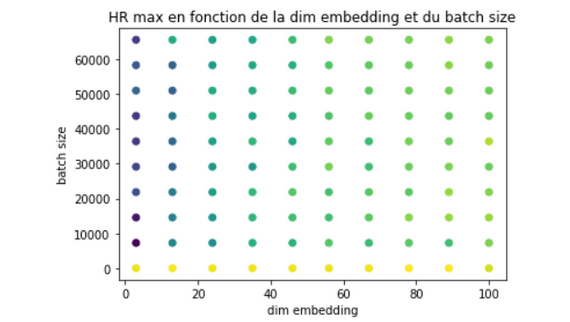

####Deuxième Grille

In [ ]:
#GMF
range_GMF_embedding_dim=np.linspace(13,90,10, dtype=int)
range_batch_size_GMF=np.linspace(10,30,10, dtype=int)
nb_epochs=10

HR_GMF=[]


for i in range_GMF_embedding_dim:
  for j in range_batch_size_GMF:
    dataloader = DataLoader(
        dataset,
        batch_size=int(j),
        shuffle=True,
        )
    
    gmf_model = GMF(
        dataset.max_user,
        dataset.max_item,
        dim_embedding=int(i),
        )
    optimizer = optim.Adam(
        gmf_model.parameters(),
        lr=1e-3,
    )

    print(f'Embedding_dim= {i}\tBatch_size = {j}')
    max_HR=train(gmf_model, nb_epochs, optimizer, dataloader, device)

    HR_GMF=HR_GMF+[max_HR]

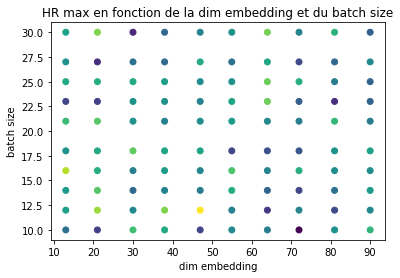

In [ ]:
#Tracé pour GMF
x=np.ones(100)
y=np.ones(100)
for i in range(10):
  x[10*i:10*(i+1)]=range_GMF_embedding_dim[i]
  y[10*i:10*(i+1)]=range_batch_size_GMF
ig = plt.figure()
ax = plt.axes()
ax.scatter(x,y,c=HR_GMF)
plt.title('HR max en fonction de la dim embedding et du batch size')
plt.xlabel("dim embedding")
plt.ylabel("batch size")
plt.show()

###MLP

####Première Grille

In [ ]:
#MLP
range_MLP_embedding_dim=np.linspace(3, 100, 10, dtype=int)
range_batch_size_MLP=np.linspace(16, 65536, 10, dtype=int)
nb_epochs=10

HR_MLP=[]

for i in range_MLP_embedding_dim:
  for j in range_batch_size_MLP:
    dataloader = DataLoader(
        dataset,
        batch_size=int(j),
        shuffle=True,
        )
    
    mlp_model = MLP(
        dataset.max_user,
        dataset.max_item,
        dim_embedding=int(i),
        dim_hidden=64,
    )
    optimizer_mlp = optim.Adam(
        mlp_model.parameters(),
        lr=1e-3,
    )

    print(f'Embedding_dim= {i}\tBatch_size = {j}')
    max_HR=train(mlp_model, nb_epochs, optimizer_mlp, dataloader, device)

    HR_MLP=HR_MLP+[max_HR]

Embedding_dim= 3	Batch_size = 16
Epoch: 1	Loss = 1.3859141640743966	HR_10 = 0.2417815482502651
Epoch: 2	Loss = 1.3766745975462056	HR_10 = 0.46129374337221635
Epoch: 3	Loss = 1.1440097123889599	HR_10 = 0.5270413573700954
Epoch: 4	Loss = 1.0852220250388322	HR_10 = 0.5355249204665959
Epoch: 5	Loss = 1.0356404377242265	HR_10 = 0.513255567338282
Epoch: 6	Loss = 1.0476003056865628	HR_10 = 0.5058324496288441
Epoch: 7	Loss = 1.0236717573666976	HR_10 = 0.5397667020148462
Epoch: 8	Loss = 0.95156636884657	HR_10 = 0.5493107104984093
Epoch: 9	Loss = 0.9510252506045972	HR_10 = 0.5334040296924708
Epoch: 10	Loss = 1.0221361416881367	HR_10 = 0.545068928950159
Embedding_dim= 3	Batch_size = 7296
Epoch: 1	Loss = 1.4412997961044312	HR_10 = 0.1357370095440085
Epoch: 2	Loss = 1.4343183040618896	HR_10 = 0.15588547189819724
Epoch: 3	Loss = 1.42778480052948	HR_10 = 0.15906680805938495
Epoch: 4	Loss = 1.4216279983520508	HR_10 = 0.14422057264050903
Epoch: 5	Loss = 1.416038990020752	HR_10 = 0.18769883351007424
Epo

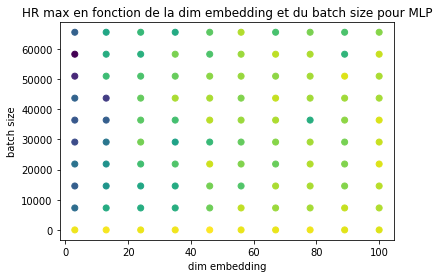

In [ ]:
#Tracé pour MLP
x=np.ones(100)
y=np.ones(100)
for i in range(10):
  x[10*i:10*(i+1)]=range_MLP_embedding_dim[i]
  y[10*i:10*(i+1)]=range_batch_size_MLP
ig = plt.figure()
ax = plt.axes()
ax.scatter(x,y,c=HR_MLP)
plt.title('HR max en fonction de la dim embedding et du batch size pour MLP')
plt.xlabel("dim embedding")
plt.ylabel("batch size")
plt.show()

In [ ]:
#Résultats 
"""
Meilleur HR pour <dim embedding>=46 , <batch_size>=16 ; HR_10 = 0.5609756097560976
#Deuxième grille dans la zone <dim embedding> dans [37, 78], <batch_size> dans [16, 1024]
"""

####Deuxième Grille

In [ ]:
#MLP
range_MLP_embedding_dim=np.linspace(37, 78, 10, dtype=int)
range_batch_size_MLP=np.linspace(16, 1024, 10, dtype=int)
nb_epochs=10

HR_MLP=[]

for i in range_MLP_embedding_dim:
  for j in range_batch_size_MLP:
    dataloader = DataLoader(
        dataset,
        batch_size=int(j),
        shuffle=True,
        )
    
    mlp_model = MLP(
        dataset.max_user,
        dataset.max_item,
        dim_embedding=int(i),
        dim_hidden=64,
    )
    optimizer_mlp = optim.Adam(
        mlp_model.parameters(),
        lr=1e-3,
    )

    print(f'Embedding_dim= {i}\tBatch_size = {j}')
    max_HR=train(mlp_model, nb_epochs, optimizer_mlp, dataloader, device)

    HR_MLP=HR_MLP+[max_HR]

Embedding_dim= 37	Batch_size = 16
Epoch: 1	Loss = 1.3514171818555412	HR_10 = 0.4602332979851538
Epoch: 2	Loss = 1.0692511887873632	HR_10 = 0.5005302226935313
Epoch: 3	Loss = 1.1145475668422247	HR_10 = 0.5005302226935313
Epoch: 4	Loss = 1.0403261568586706	HR_10 = 0.5270413573700954
Epoch: 5	Loss = 1.0170562499660556	HR_10 = 0.513255567338282
Epoch: 6	Loss = 1.0513375936928442	HR_10 = 0.5164369034994698
Epoch: 7	Loss = 1.020909879167201	HR_10 = 0.5630965005302226
Epoch: 8	Loss = 0.9851120195146335	HR_10 = 0.5079533404029692
Epoch: 9	Loss = 0.9650373054763018	HR_10 = 0.5440084835630965
Epoch: 10	Loss = 0.9539091920448561	HR_10 = 0.5567338282078473
Embedding_dim= 37	Batch_size = 128
Epoch: 1	Loss = 1.3858522176742554	HR_10 = 0.27465535524920465
Epoch: 2	Loss = 1.3854914605617523	HR_10 = 0.41993637327677624
Epoch: 3	Loss = 1.3820468187332153	HR_10 = 0.4835630965005302
Epoch: 4	Loss = 1.3741938173770905	HR_10 = 0.49946977730646874
Epoch: 5	Loss = 1.3522017896175385	HR_10 = 0.5174973488865323

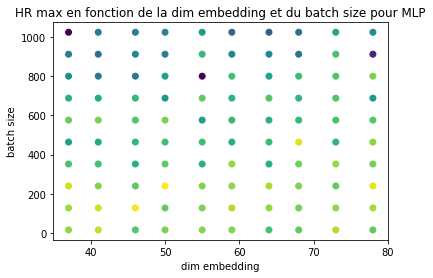

In [ ]:
#Tracé pour MLP
x=np.ones(100)
y=np.ones(100)
for i in range(10):
  x[10*i:10*(i+1)]=range_MLP_embedding_dim[i]
  y[10*i:10*(i+1)]=range_batch_size_MLP
ig = plt.figure()
ax = plt.axes()
ax.scatter(x,y,c=HR_MLP)
plt.title('HR max en fonction de la dim embedding et du batch size pour MLP')
plt.xlabel("dim embedding")
plt.ylabel("batch size")
plt.show()

In [ ]:
#Résultats 
"""
Meilleur HR pour <dim embedding>=46 , <batch_size>=128 ; HR_10 = 0.5896076352067868
"""

###NeuMF

In [ ]:
#NeuMF
#On choisit les paramètres optimaux déterminés précédemment pour entraîner le modèle
NeuMF_MLP_embedding_dim=46
batch_size_NeuMF__MLP=128

NeuMF_GMF_embedding_dim=47
NeuMF_GMF_batch_size=12

range_NeuMF_batch_size=np.linspace(12, 2000,10, dtype=int)
range_NeuMF_lr=np.linspace(0.0001, 0.05, 10)

nb_epochs=10

HR_NeuMF=[]



for i in range_NeuMF_batch_size:
  for j in range_NeuMF_lr:

    #gmf
    dataloader_gmf = DataLoader(
        dataset,
        batch_size=NeuMF_GMF_batch_size,
        shuffle=True,
        )
    
    gmf_model = GMF(
        dataset.max_user,
        dataset.max_item,
        dim_embedding=NeuMF_GMF_embedding_dim
        )
    
    optimizer_gmf = optim.Adam(
        gmf_model.parameters(),
        lr=1e-3,
        )
    train(gmf_model, nb_epochs, optimizer_gmf, dataloader_gmf, device)

    #mlp
    
    dataloader_mlp = DataLoader(
        dataset,
        batch_size=batch_size_NeuMF__MLP,
        shuffle=True,
        )

    mlp_model = MLP(
        dataset.max_user,
        dataset.max_item,
        dim_embedding=NeuMF_MLP_embedding_dim,
        dim_hidden=64,
        )
    
    optimizer_mlp = optim.Adam(
        mlp_model.parameters(),
        lr=1e-3,
        )
    
    train(mlp_model, nb_epochs, optimizer_mlp, dataloader_mlp, device)

    #NeuMF

    dataloader_NeuMF = DataLoader(
        dataset,
        batch_size=int(i),
        shuffle=True,
        )

    neumf_model = NeuMF(
        gmf_model,
        mlp_model,
        alpha=0.5,
        )

    optimizer_NeuMF = optim.Adam(
        neumf_model.parameters(),
        lr=int(j),
        )
    print(f'BatchSize_NeuMF= {i}\tLearning_rate = {j}')
    max_HR=train(neumf_model, nb_epochs, optimizer_NeuMF, dataloader_NeuMF, device)

    HR_NeuMF=HR_NeuMF+[max_HR]







Epoch: 1	Loss = 1.3827775279177894	HR_10 = 0.41039236479321317
Epoch: 2	Loss = 1.3473767525033107	HR_10 = 0.4867444326617179
Epoch: 3	Loss = 1.240806736523592	HR_10 = 0.5514316012725344
Epoch: 4	Loss = 1.12348741745647	HR_10 = 0.5397667020148462
Epoch: 5	Loss = 1.0536234092108812	HR_10 = 0.5535524920466596
Epoch: 6	Loss = 1.0082564504840705	HR_10 = 0.5291622481442205
Epoch: 7	Loss = 1.0248037516316282	HR_10 = 0.5652173913043478
Epoch: 8	Loss = 1.0009863799131369	HR_10 = 0.5641569459172853
Epoch: 9	Loss = 1.0203033331074292	HR_10 = 0.5334040296924708
Epoch: 10	Loss = 1.0108469249326972	HR_10 = 0.5652173913043478
Epoch: 1	Loss = 1.3905713856220245	HR_10 = 0.3022269353128314
Epoch: 2	Loss = 1.3841750621795654	HR_10 = 0.4432661717921527
Epoch: 3	Loss = 1.3808484375476837	HR_10 = 0.503711558854719
Epoch: 4	Loss = 1.3705863803625107	HR_10 = 0.49628844114528103
Epoch: 5	Loss = 1.3467715233564377	HR_10 = 0.5461293743372216
Epoch: 6	Loss = 1.296974077820778	HR_10 = 0.5323435843054083
Epoch: 7	L

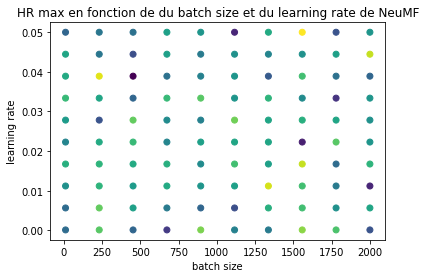

In [ ]:
#Tracé pour NeuMF
x=np.ones(100)
y=np.ones(100)
for i in range(10):
  x[10*i:10*(i+1)]=range_NeuMF_batch_size[i]
  y[10*i:10*(i+1)]=range_NeuMF_lr
ig = plt.figure()
ax = plt.axes()
ax.scatter(x,y,c=HR_NeuMF)
plt.title('HR max en fonction de du batch size et du learning rate de NeuMF')
plt.xlabel("batch size")
plt.ylabel("learning rate")
plt.show()

##Tests pour le nombre de négatifs

###GMF

In [ ]:
GMF_HR=[]
GMF_NDGC=[]



for i in range(1,11):

  dataset = MFDataset(matrix, i)

  dataloader = DataLoader(
    dataset,
    batch_size=12,
    shuffle=True,
    )

  gmf_model = GMF(
      dataset.max_user,
      dataset.max_item,
      dim_embedding=47,
      )
  optimizer_gmf = optim.Adam(
      gmf_model.parameters(),
      lr=1e-3,
  )

  HR, NDGC = train(gmf_model, 10, optimizer_gmf, dataloader, device)

  GMF_HR = GMF_HR + [HR]
  GMF_NDGC = GMF_NDGC + [NDGC]

Epoch: 1	Loss = 1.381490348260614	HR_10 = 0.4061505832449629	NDGC_10 = 0.36222754762277576
Epoch: 2	Loss = 1.3403726378573646	HR_10 = 0.48886532343584305	NDGC_10 = 0.4000380813800047
Epoch: 3	Loss = 1.2307484044304378	HR_10 = 0.5291622481442205	NDGC_10 = 0.4089671757384398
Epoch: 4	Loss = 1.1145319018182875	HR_10 = 0.5068928950159067	NDGC_10 = 0.4025970571153714
Epoch: 5	Loss = 1.0364694474618645	HR_10 = 0.5577942735949099	NDGC_10 = 0.4108315390961147
Epoch: 6	Loss = 1.0261685025842884	HR_10 = 0.5567338282078473	NDGC_10 = 0.40413892754507197
Epoch: 7	Loss = 1.0137913958935798	HR_10 = 0.545068928950159	NDGC_10 = 0.41619882983667583
Epoch: 8	Loss = 1.0107213432275797	HR_10 = 0.5471898197242842	NDGC_10 = 0.42628821648609444
Epoch: 9	Loss = 0.9653700839115095	HR_10 = 0.5546129374337222	NDGC_10 = 0.41686744737643705
Epoch: 10	Loss = 0.9636042087892943	HR_10 = 0.5174973488865323	NDGC_10 = 0.40212750464879676
Epoch: 1	Loss = 1.9217424377610413	HR_10 = 0.4411452810180276	NDGC_10 = 0.3504423727

###MLP

In [ ]:
MLP_HR=[]
MLP_NDGC=[]

for i in range(1,11):

  dataset = MFDataset(matrix, i)

  dataloader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    )

  mlp_model = MLP(
      dataset.max_user,
      dataset.max_item,
      dim_embedding=46,
      dim_hidden=64
      )
  optimizer_mlp = optim.Adam(
      mlp_model.parameters(),
      lr=1e-3,
  )

  HR, NDGC = train(mlp_model, 10, optimizer_mlp, dataloader, device)

  MLP_HR = MLP_HR + [HR]
  MLP_NDGC = MLP_NDGC + [NDGC]

Epoch: 1	Loss = 1.3919552564620972	HR_10 = 0.2863202545068929	NDGC_10 = 0.2917918497078687
Epoch: 2	Loss = 1.3851116299629211	HR_10 = 0.4252386002120891	NDGC_10 = 0.3516119522461609
Epoch: 3	Loss = 1.3838067650794983	HR_10 = 0.4740190880169671	NDGC_10 = 0.3732981934274199
Epoch: 4	Loss = 1.379537284374237	HR_10 = 0.5143160127253447	NDGC_10 = 0.4129631621550356
Epoch: 5	Loss = 1.3697717040777206	HR_10 = 0.5323435843054083	NDGC_10 = 0.39826996700961514
Epoch: 6	Loss = 1.345481052994728	HR_10 = 0.5068928950159067	NDGC_10 = 0.41103334912278056
Epoch: 7	Loss = 1.2953743487596512	HR_10 = 0.5259809119830329	NDGC_10 = 0.4042398149899941
Epoch: 8	Loss = 1.2052864879369736	HR_10 = 0.5577942735949099	NDGC_10 = 0.4225597753633603
Epoch: 9	Loss = 1.1112302988767624	HR_10 = 0.5588547189819725	NDGC_10 = 0.4208031212449591
Epoch: 10	Loss = 1.02504713088274	HR_10 = 0.5567338282078473	NDGC_10 = 0.43301478986363806
Epoch: 1	Loss = 2.236461788415909	HR_10 = 0.2598091198303287	NDGC_10 = 0.2712661747452088


###NeuMF

In [ ]:
NeuMF_HR=[]
NeuMF_NDGC=[]

for i in range(1,11):

  dataset = MFDataset(matrix, i)
  dataloader_NeuMF = DataLoader(
      dataset,
      batch_size=1558,
      shuffle=True,
      )

  neumf_model = NeuMF(
      gmf_model,
      mlp_model,
      alpha=0.5,
  )

  optimizer_NeuMF = optim.Adam(
      neumf_model.parameters(),
      lr=0.05
  )

  HR, NDGC = train(neumf_model, 10, optimizer_NeuMF, dataloader_NeuMF, device)
  NeuMF_HR = NeuMF_HR + [HR]
  NeuMF_NDGC = NeuMF_NDGC + [NDGC]

Epoch: 1	Loss = 1.0842092037200928	HR_10 = 0.5715800636267232	NDGC_10 = 0.413495202185794
Epoch: 2	Loss = 1.1487905979156494	HR_10 = 0.5514316012725344	NDGC_10 = 0.41176411211617764
Epoch: 3	Loss = 1.0708258152008057	HR_10 = 0.5556733828207847	NDGC_10 = 0.41107033827156675
Epoch: 4	Loss = 1.0060956478118896	HR_10 = 0.5344644750795334	NDGC_10 = 0.4161341947669316
Epoch: 5	Loss = 1.032755970954895	HR_10 = 0.5567338282078473	NDGC_10 = 0.4076797401855863
Epoch: 6	Loss = 1.0876070261001587	HR_10 = 0.5588547189819725	NDGC_10 = 0.42049192971283633
Epoch: 7	Loss = 1.0500273704528809	HR_10 = 0.545068928950159	NDGC_10 = 0.4206407342157187
Epoch: 8	Loss = 1.0129096508026123	HR_10 = 0.5514316012725344	NDGC_10 = 0.42413437838098733
Epoch: 9	Loss = 1.0883902311325073	HR_10 = 0.5683987274655355	NDGC_10 = 0.4065708076413261
Epoch: 10	Loss = 1.086949348449707	HR_10 = 0.542948038176034	NDGC_10 = 0.4189076284332939
Epoch: 1	Loss = 4.620367050170898	HR_10 = 0.2831389183457052	NDGC_10 = 0.27914260783245703

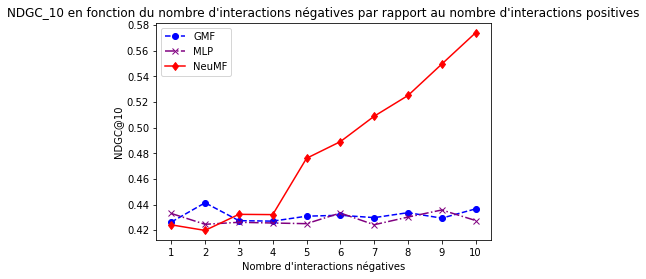

In [ ]:
plot_3_models(GMF_NDGC, MLP_NDGC, NeuMF_NDGC, "NDGC@10", "NDGC_10 en fonction du nombre d'interactions négatives par rapport au nombre d'interactions positives","Nombre d'interactions négatives", True)

#Test des modèles avec paramètres optimisés

In [ ]:
dataset = MFDataset(matrix, 1)

dataloader = DataLoader(
  dataset,
  batch_size=12,
  shuffle=True,
  )

gmf_model = GMF(
    dataset.max_user,
    dataset.max_item,
    dim_embedding=47,
    )
optimizer_gmf = optim.Adam(
    gmf_model.parameters(),
    lr=1e-3,
)

GMF_HR, GMF_NDGC= train(gmf_model, 50, optimizer_gmf, dataloader, device)

Epoch: 1	Loss = 1.3819351151019712	HR_10 = 0.391304347826087	NDGC_10 = 0.35947140526691646
Epoch: 2	Loss = 1.3424912781655034	HR_10 = 0.503711558854719	NDGC_10 = 0.38897140772172767
Epoch: 3	Loss = 1.2192574543288992	HR_10 = 0.5302226935312832	NDGC_10 = 0.3977112945061212
Epoch: 4	Loss = 1.0900940714003164	HR_10 = 0.5111346765641569	NDGC_10 = 0.4028539893920981
Epoch: 5	Loss = 1.0363480433633057	HR_10 = 0.5249204665959704	NDGC_10 = 0.41205316262856584
Epoch: 6	Loss = 1.031826627405384	HR_10 = 0.5312831389183457	NDGC_10 = 0.4030850626428542
Epoch: 7	Loss = 0.9880398851406725	HR_10 = 0.5302226935312832	NDGC_10 = 0.40209786737828035
Epoch: 8	Loss = 1.020365682583821	HR_10 = 0.5503711558854719	NDGC_10 = 0.41847690396931325
Epoch: 9	Loss = 0.9537268386611456	HR_10 = 0.5673382820784729	NDGC_10 = 0.39846224431835536
Epoch: 10	Loss = 0.9724801039393944	HR_10 = 0.5694591728525981	NDGC_10 = 0.4082791957467256
Epoch: 11	Loss = 0.9725440763220002	HR_10 = 0.5365853658536586	NDGC_10 = 0.402034734208

In [ ]:
dataset = MFDataset(matrix, 1)

dataloader = DataLoader(
  dataset,
  batch_size=128,
  shuffle=True,
  )

mlp_model = MLP(
    dataset.max_user,
    dataset.max_item,
    dim_embedding=47,
    dim_hidden=64
    )
optimizer_mlp = optim.Adam(
    mlp_model.parameters(),
    lr=1e-3,
)

MLP_HR, MLP_NDGC, MLP_loss = train(mlp_model, 50, optimizer_mlp, dataloader, device)

Epoch: 1	Loss = 1.386093720793724	HR_10 = 0.2767762460233298	NDGC_10 = 0.28831877634680975
Epoch: 2	Loss = 1.384878784418106	HR_10 = 0.41569459172852596	NDGC_10 = 0.3629747887779102
Epoch: 3	Loss = 1.3812076896429062	HR_10 = 0.4909862142099682	NDGC_10 = 0.3741495263165218
Epoch: 4	Loss = 1.3687233477830887	HR_10 = 0.5206786850477201	NDGC_10 = 0.3922292200276039
Epoch: 5	Loss = 1.331774964928627	HR_10 = 0.5249204665959704	NDGC_10 = 0.42340107485088385
Epoch: 6	Loss = 1.2699875235557556	HR_10 = 0.5249204665959704	NDGC_10 = 0.4033473180026486
Epoch: 7	Loss = 1.1464096158742905	HR_10 = 0.5387062566277837	NDGC_10 = 0.40996076315672275
Epoch: 8	Loss = 1.054757609963417	HR_10 = 0.5217391304347826	NDGC_10 = 0.40933507125700125
Epoch: 9	Loss = 1.0455519407987595	HR_10 = 0.5418875927889714	NDGC_10 = 0.39926281958407445
Epoch: 10	Loss = 1.0359158217906952	HR_10 = 0.5376458112407211	NDGC_10 = 0.4130281820043008
Epoch: 11	Loss = 0.9727529436349869	HR_10 = 0.545068928950159	NDGC_10 = 0.4243244792810

In [ ]:
dataset = MFDataset(matrix, 1)
                    
gmf_model = GMF(
    dataset.max_user,
    dataset.max_item,
    dim_embedding=47,
    )

mlp_model = MLP(
    dataset.max_user,
    dataset.max_item,
    dim_embedding=46,
    dim_hidden=64
    )      
                    
dataloader_NeuMF = DataLoader(
    dataset,
    batch_size=1558,
    shuffle=True,
    )

neumf_model = NeuMF(
    gmf_model,
    mlp_model,
    alpha=0.5,
)

optimizer_NeuMF = optim.Adam(
    neumf_model.parameters(),
    lr=0.05
)

NeuMF_HR, NeuMF_NDGC, NeuMF_loss = train(neumf_model, 50, optimizer_NeuMF, dataloader_NeuMF, device)

Epoch: 1	Loss = 1.46244478225708	HR_10 = 0.3955461293743372	NDGC_10 = 0.31325578492419814
Epoch: 2	Loss = 1.385899305343628	HR_10 = 0.1823966065747614	NDGC_10 = 0.23324312249912937
Epoch: 3	Loss = 1.3490214347839355	HR_10 = 0.4835630965005302	NDGC_10 = 0.3611557728072109
Epoch: 4	Loss = 1.277098298072815	HR_10 = 0.4973488865323436	NDGC_10 = 0.37525381217882803
Epoch: 5	Loss = 1.1254018545150757	HR_10 = 0.5206786850477201	NDGC_10 = 0.39466405134456134
Epoch: 6	Loss = 1.2479214668273926	HR_10 = 0.49628844114528103	NDGC_10 = 0.40290643014956984
Epoch: 7	Loss = 1.2598845958709717	HR_10 = 0.5217391304347826	NDGC_10 = 0.4056036622011508
Epoch: 8	Loss = 0.9982002973556519	HR_10 = 0.5344644750795334	NDGC_10 = 0.4131101678160058
Epoch: 9	Loss = 1.029109001159668	HR_10 = 0.5440084835630965	NDGC_10 = 0.4036932273651628
Epoch: 10	Loss = 0.9994772672653198	HR_10 = 0.542948038176034	NDGC_10 = 0.4124349601621866
Epoch: 11	Loss = 0.9691685438156128	HR_10 = 0.5567338282078473	NDGC_10 = 0.41815577171991